## Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

## Data Processing

In [ ]:
#load the dataset
data = pd.read_csv('healthcare_dataset.csv') #13,000 entries of cleaned data

#drop unnecessary columns
columns_to_drop = ['Name', 'Date of Admission', 'Discharge Date', 'Doctor', 'Hospital', 'Room Number']
data = data.drop(columns=columns_to_drop, axis=1)

#encode categorical variables
data = pd.get_dummies(data, drop_first=True)

#handle missing values (just incase)
data.fillna(data.mean(), inplace=True)

#splitting predictors and target
X = data.drop('Test Results_Normal', axis=1) 
y = data['Test Results_Normal']

## Train-Test Split, Feature Scaling & SMOTE

In [8]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#applied SMOTE to balance dataset (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

## Hyperparameter Tuning for K-NN (Cross-Validation)

In [10]:
#cross-validation to select best k
accuracies = []
k_range = range(1, 114)  #best range for data

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='distance')
    cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    accuracies.append(np.mean(cv_scores))

best_k = k_range[np.argmax(accuracies)]  #gets best k based off cross-validation
best_accuracy = max(accuracies)

print(f"Best K (via cross-validation): {best_k} with accuracy: {best_accuracy:.2f}%")

#training final k-nn model
knn = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean', weights='distance')
knn.fit(X_train_smote, y_train_smote)
y_knn_pred = knn.predict(X_test_scaled)

Best K (via cross-validation): 65 with accuracy: 0.68%


## Training & Evaluating K-NN Model

In [12]:
#list of distance values
distance_metrics = ['euclidean', 'manhattan', 'minkowski']
best_k = 0
best_accuracy = 0
best_metric = ''

for k in range(1, 114):
    for metric in distance_metrics: #tests all distance values (from 1 - 113)
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights='distance')
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > best_accuracy: #stores best result
            best_accuracy = accuracy
            best_k = k
            best_metric = metric

#k-nn loop results
print("Results from K-NN loop")
print(f"Best K: {best_k}")
print(f"Best Metric: {best_metric}")
print(f"Best Metric: {best_accuracy:.2f}")

#k-nn eval
print("\nK-NN Classification Report:")
print(classification_report(y_test, y_knn_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_knn_pred))

Results from K-NN loop
Best K: 25
Best Metric: euclidean
Best Metric: 0.68

K-NN Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.50      0.65      2603
        True       0.48      0.93      0.63      1297

    accuracy                           0.64      3900
   macro avg       0.71      0.72      0.64      3900
weighted avg       0.78      0.64      0.65      3900

Confusion Matrix:
[[1312 1291]
 [  94 1203]]


## Logistic Regression Training

In [14]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_smote, y_train_smote)
y_log_pred = log_reg.predict(X_test_scaled)

## Accuracy Comparison

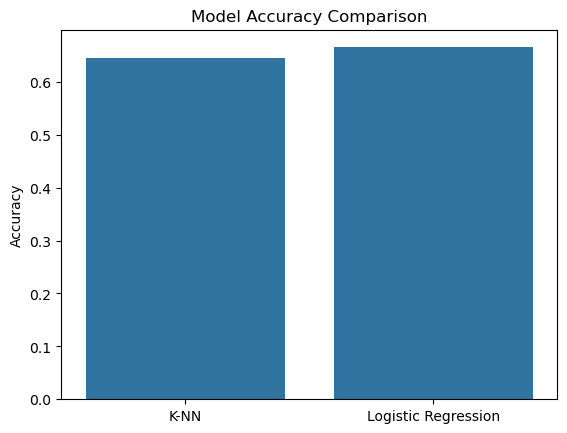

In [16]:
knn_accuracy = accuracy_score(y_test, y_knn_pred)
log_accuracy = accuracy_score(y_test, y_log_pred)

models = ['K-NN', 'Logistic Regression']
accuracies = [knn_accuracy, log_accuracy]

sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()